In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [313]:
from utils import dataset_INCan, patient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# normalize the features
from sklearn.preprocessing import StandardScaler
# simple SVM classifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# use leave one out cross validation
from sklearn.model_selection import LeaveOneOut
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve

We normalize the data to have zero mean and unit variance (Standard Scaling).
- We may try other normalization?
- In practice SVM and most of the other algorithms work better if the features are normalized like this.

# OLD Version

In [218]:
# # get X values
# features = pd.read_csv(repo_path / 'data/deep/features/features_1024/V_1_features.csv')
# # remove the first column
# features = features.iloc[:,1:]
# # get y values
# labels = dataset_INCan().labels_list(receptor='RE')
# # labels to df
# labels = pd.DataFrame(labels, columns=['label'])
# # print label distribution porcentage
# print(labels['label'].value_counts(normalize=True).values[0].round(3))

# # create the scaler
# scaler = StandardScaler()
# # fit the scaler
# scaler.fit(features)
# # transform the features
# features = pd.DataFrame(scaler.transform(features))

# # create the classifier
# clf = SVC(kernel='linear', C=0.1, gamma=0.1, probability=True)
# # create the cross validation
# loo = LeaveOneOut()
# # get the number of samples
# n_samples = len(features)
# # create the predictions list
# predictions = []
# true_labels = []
# probabilities = []
# # iterate over the samples
# for train_index, test_index in loo.split(features):
#     # get the train and test data
#     X_train, X_test = features.iloc[train_index], features.iloc[test_index]
#     # get the train and test labels
#     y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
#     # fit the model
#     clf.fit(X_train, y_train.values.ravel())
#     # predict the test sample
#     y_pred = clf.predict(X_test)
#     # predict the probability
#     y_prob = clf.predict_proba(X_test)
#     # append the prediction
#     predictions.append(y_pred)
#     probabilities.append(y_prob)
#     true_labels.append(y_test.values[0])
# # convert the predictions to array
# predictions = np.asarray(predictions)
# true_labels = np.asarray(true_labels)
# probabilities = np.asanyarray(probabilities).reshape(-1,2)[:,0]

# # compute roc
# roc_auc = roc_auc_score(true_labels, probabilities)

# # # get metrics scores
# # accuracy = accuracy_score(true_labels, predictions)
# # precision = precision_score(true_labels, predictions)
# # recall = recall_score(true_labels, predictions)
# # f1 = f1_score(true_labels, predictions)

# # # print the scores all together
# # print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}, \nROC_AUC: {roc_auc}\n')

# # # display the confusion matrix
# # cm = confusion_matrix(true_labels, predictions)
# # ConfusionMatrixDisplay(cm).plot()
# # plt.title('Confusion Matrix')

# # plot the ROC curve

# fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
# plt.figure()
# plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
# plt.plot([0,1],[0,1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# # get ideal threshold
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]
# # plot the optimal threshold
# plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best Threshold')
# plt.legend()

# # get optimal predictions
# optimal_predictions = np.where(probabilities > optimal_threshold, 1, 0)
# # get metrics scores
# accuracy = accuracy_score(true_labels, optimal_predictions)
# precision = precision_score(true_labels, optimal_predictions)
# recall = recall_score(true_labels, optimal_predictions)
# f1 = f1_score(true_labels, optimal_predictions)

# # print the scores all together
# print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}')
# # display the confusion matrix
# cm = confusion_matrix(true_labels, optimal_predictions)
# ConfusionMatrixDisplay(cm).plot()


# New Version: OO

In [319]:
# create predictor class
class predictor_machine():
    def __init__(self):
        self.scaler = StandardScaler()
        self.clf = None
        self.cv = LeaveOneOut()
        self.features = None
        self.num_samples = 0
        self.labels = None
        # lists
        self.probabilities = []
        self.true_labels = []
        self.best_params = []

    def scale_features(self, features:pd.DataFrame):
        """with the defined scaler, scale feature and return as a dataframe

        Args:
            features (pd.DataFrame): input features, in order of prediction. Only numerical values.

        Returns:
            pd.DataFrame: scaled features
        """
        self.scaler.fit(features)
        features = pd.DataFrame(self.scaler.transform(features))
        self.num_samples = len(features)

        self.features = features

    def prepare_labels(self, labels:list, show_distribution:bool=False):
        # labels to df
        labels = pd.DataFrame(labels, columns=['label'])
        if show_distribution:
            print(f'The positive cases represent {labels["label"].mean().round(3)*100}%')
        
        self.labels = labels

    def train(self):
        for train_index, test_index in self.cv.split(self.features):
            # get the train and test data
            X_train, X_test = self.features.iloc[train_index], self.features.iloc[test_index]
            # get the train and test labels
            y_train, y_test = self.labels.iloc[train_index], self.labels.iloc[test_index]
            # fit the model
            self.clf.fit(X_train, y_train.values.ravel())
            # save best params of this iteration
            self.best_params.append(self.clf.best_params_)
            # predict the probability
            y_prob = self.clf.predict_proba(X_test)
            # append the prediction
            self.probabilities.append(y_prob)
            self.true_labels.append(y_test.values[0])
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels)
        self.probabilities = np.asanyarray(self.probabilities).reshape(-1,2)[:,0]

        print(f'Training finished!')

    def compute_metrics(self, plot_roc:bool=False, plot_CM:bool=False):
        
        roc_auc = roc_auc_score(self.true_labels, self.probabilities)
        fpr, tpr, thresholds = roc_curve(self.true_labels, self.probabilities)
        # get ideal threshold
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        if plot_roc:
            plt.figure()
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
            plt.plot([0,1],[0,1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label=f'Best Threshold: {optimal_threshold.round(3)}')
            plt.legend()
            plt.show()
        # get optimal predictions
        optimal_predictions = np.where(self.probabilities > optimal_threshold, 1, 0)
        accuracy = accuracy_score(self.true_labels, optimal_predictions)
        precision = precision_score(self.true_labels, optimal_predictions)
        recall = recall_score(self.true_labels, optimal_predictions)
        f1 = f1_score(self.true_labels, optimal_predictions)
        print(f'AUC:{roc_auc}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}')
        if plot_CM:
            cm = confusion_matrix(self.true_labels, optimal_predictions)
            ConfusionMatrixDisplay(cm).plot()
            plt.show()
                    

The positive cases represent 81.8%
Training finished!


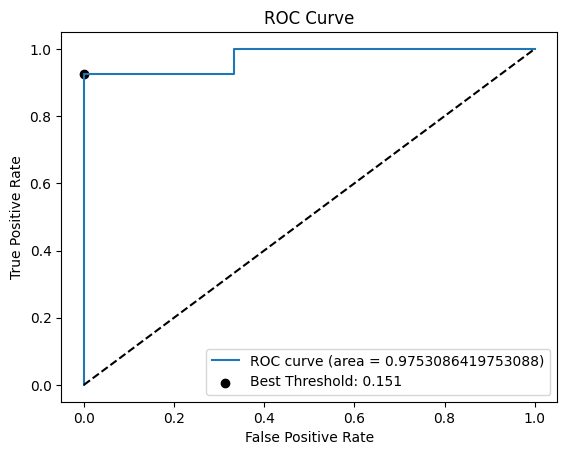

AUC:0.9753086419753088
Accuracy: 0.9090909090909091
Precision: 1.0
Recall: 0.8888888888888888
F1: 0.9411764705882353


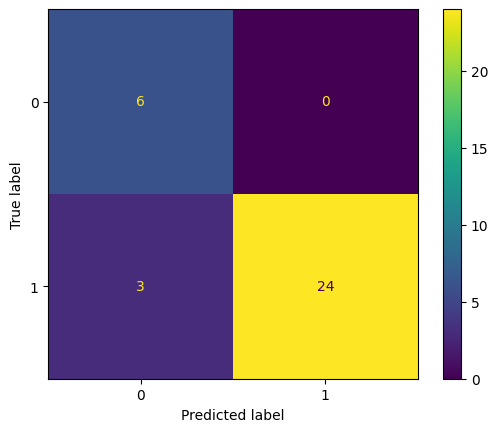

In [359]:
# get the features, remove the first column (patient ID)
features = pd.read_csv(repo_path / 'data/deep/features/features_1024/V_1_features.csv').iloc[:,1:]
labels = dataset_INCan().labels_list(receptor='RE')

# prepare for the machine
predictor = predictor_machine()


# grid search
parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1, 10], 'gamma':[0.01, 0.1, 1]}
# define the classifier
pred = SVC(probability=True)
# define the grid search, the best model is selected based on the roc_auc score
predictor.clf = GridSearchCV(pred, parameters, cv=3, scoring='roc_auc', verbose=0, n_jobs=6)


predictor.scale_features(features)
predictor.prepare_labels(labels, show_distribution=True)
predictor.train()
predictor.compute_metrics(plot_roc=True, plot_CM=True)